In [1]:
import os
import pandas as pd
import requests
import utils
import json

import geopandas as gpd
import numpy as np

from consts import *

In [2]:
if not os.path.exists(DISTRICTS_PATH):
    query_params = {
        "where": "1=1",
        "f": "geojson"
    }
    response = requests.get(DISTRICTS_URL, params=query_params)
    districts_data = response.json()["features"]
    json.dump(districts_data, open(DISTRICTS_PATH, "w"))


In [3]:
districts_data = json.load(open(DISTRICTS_PATH, "r"))


In [4]:
import matplotlib.pyplot as plt
from colors import colors

districts_gdf = gpd.read_file(DATA_DIR.joinpath("districts.geojson"))


In [5]:
districts_gdf = districts_gdf[districts_gdf[NAME] != "Endine Tähtvere vald"]


In [9]:
districts_gdf

,NIMI,geometry
0,Ropka,"POLYGON ((26.74109 58.36004, 26.74089 58.35981..."
1,Variku,"POLYGON ((26.69461 58.34718, 26.70175 58.34494..."
2,Ihaste,"POLYGON ((26.75972 58.35927, 26.75470 58.35715..."
3,Maarjamõisa,"POLYGON ((26.70067 58.36634, 26.70349 58.36680..."
4,Tammelinna,"POLYGON ((26.70456 58.37480, 26.69920 58.37352..."
5,Annelinna,"POLYGON ((26.75972 58.35927, 26.76041 58.35793..."
6,Ülejõe,"POLYGON ((26.70882 58.39329, 26.70882 58.39329..."
8,Supilinna,"POLYGON ((26.72200 58.38642, 26.71923 58.38792..."
9,Veeriku,"POLYGON ((26.67367 58.40456, 26.66707 58.40580..."
10,Ropka tööstuse,"POLYGON ((26.73371 58.35516, 26.73290 58.35521..."


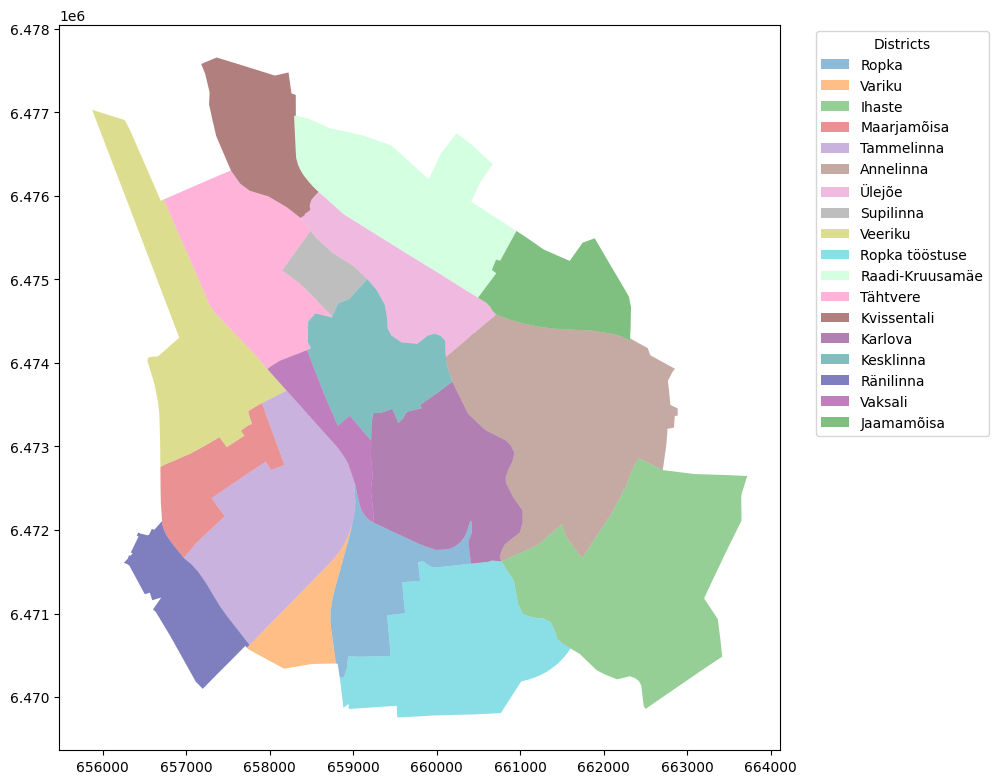

In [8]:
polygons = districts_gdf.to_crs(3301)
fig, ax = plt.subplots(figsize=(10,10))

polygons['color'] = colors
polygons.plot(ax=ax, color=polygons['color'], legend=True, alpha=0.5)

handles = []
labels = []
for item in polygons.iterrows():
    name = item[1][NAME]
    color = item[1]['color']
    handles.append(plt.Rectangle((0, 0), 1, 1, fc=color, alpha=0.5))
    labels.append(name)

plt.legend(handles, labels, bbox_to_anchor=(1.04, 1), loc="upper left", title='Districts', frameon=True)
plt.tight_layout()
plt.show()


In [4]:
districts_geometry = {}
for disctrict in districts_data:
    coordinates = disctrict["geometry"]["coordinates"]
    name = disctrict["properties"][NAME]
    districts_geometry[name] = coordinates


In [3]:
estimated_production_by_roof = pd.read_csv(ROOFS_PATH)


In [4]:
estimated_production_by_roof.groupby([ETAK_ID]).size()

etak_id
333302     2
333303     3
333305     3
333306     2
333307     2
          ..
8227643    2
8300044    2
8300386    2
8300612    2
8305846    2
Length: 20884, dtype: int64

In [5]:
estimated_production_by_building = estimated_production_by_roof[[
    ETAK_ID, LAT, LON, TOTAL_ROOF_AREA]].drop_duplicates()


In [8]:
map_coordinates_to_district_vectorized = np.vectorize(
    utils.map_coordinates_to_district, excluded=["districts"])
estimated_production_by_building["district"] = map_coordinates_to_district_vectorized(
    estimated_production_by_building.lat,
    estimated_production_by_building.lon,
    districts_geometry
)


In [9]:
estimated_production_by_building[ANNUAL_KWH] = estimated_production_by_roof.groupby(ETAK_ID)[ANNUAL_KWH]\
    .transform("sum")


In [10]:
calculate_pv_area_vect = np.vectorize(
    utils.calculate_pv_area, excluded=["roof_area_pv_ratio"])
estimated_production_by_building[PV_AREA_M2] = calculate_pv_area_vect(
    estimated_production_by_building[TOTAL_ROOF_AREA],
    ROOF_AREA_PV_RATIO
)

calculate_annual_kwh_pv_m2_vect = np.vectorize(
    utils.calculate_annual_kwh_pv_m2)
estimated_production_by_building[ANNUAL_KWH_PV_M2] = calculate_annual_kwh_pv_m2_vect(
    estimated_production_by_building[ANNUAL_KWH],
    estimated_production_by_building[PV_AREA_M2]
)


In [11]:
estimated_production_by_roof

,etak_id,roof_id,annual_kwh,monthly_average_kwh,roof_area,azimuth,tilt,orientation,total_roof_area,lat,...,Mar_kwh/pv_m2,Apr_kwh/pv_m2,May_kwh/pv_m2,Jun_kwh/pv_m2,Jul_kwh/pv_m2,Aug_kwh/pv_m2,Sep_kwh/pv_m2,Oct_kwh/pv_m2,Nov_kwh/pv_m2,Dec_kwh/pv_m2
0,7106760,1,5242.83,436.90,26.198233,-96.837100,4.921,none,26.20,58.345708,...,20.705807,26.478037,32.002583,30.600453,30.634806,26.925905,20.265150,11.242065,4.136835,2.934888
1,728449,2,6839.15,569.93,34.221977,94.493128,7.901,none,34.22,58.354539,...,20.284236,26.673568,32.294063,30.689831,30.864507,26.926817,20.193327,11.374757,4.124705,2.780864
2,737756,3,4339.29,361.61,23.309351,-43.279136,31.058,south,204.24,58.357790,...,17.739661,24.697765,32.034354,31.292639,30.899378,25.923787,18.009463,9.313859,3.016910,1.953913
3,737756,4,2319.89,193.32,19.183207,135.375705,31.538,north,204.24,58.357790,...,8.358584,15.770738,23.411680,25.436020,24.389967,17.918450,9.896387,4.044046,1.125985,0.468581
4,737756,5,8657.23,721.44,71.746268,-134.736848,30.623,east,204.24,58.357790,...,8.666963,15.514241,23.596581,25.204873,23.983593,17.788149,10.014148,4.106601,1.129753,0.472653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79438,724636,79439,915.09,76.26,6.919663,126.304497,27.131,west,747.13,58.362351,...,9.576574,17.587561,25.423523,27.132020,26.133256,19.522465,11.159823,4.632531,1.234806,0.484930
79439,724636,79440,873.90,72.83,6.602727,126.236821,27.069,west,747.13,58.362351,...,9.583582,17.602155,25.444033,27.148715,26.152494,19.539065,11.172152,4.637814,1.236863,0.484648
79440,724636,79441,867.44,72.29,6.548483,126.098284,27.052,west,747.13,58.362351,...,9.598491,17.619009,25.461368,27.161508,26.167215,19.554996,11.186645,4.645690,1.236928,0.483573
79441,711101,79442,2023.34,168.61,10.122619,96.483074,8.288,none,33.79,58.365328,...,20.288996,26.677330,32.296210,30.690345,30.865969,26.928692,20.196794,11.379356,4.128269,2.784743


In [12]:
estimated_production_by_building


,etak_id,lat,lon,total_roof_area,district,annual_kwh,pv_area_m2,annual_kwh/pv_m2
0,7106760,58.345708,26.723822,26.20,Ropka tööstuse,5242.83,23.580,222.342239
1,728449,58.354539,26.727600,34.22,Ropka,6839.15,30.798,222.064744
2,737756,58.357790,26.790659,204.24,Ihaste,31988.55,183.816,174.024840
6,710836,58.367784,26.729952,32.82,Karlova,6561.06,29.538,222.122689
7,726205,58.352388,26.717920,19.45,Ropka,2701.48,17.505,154.326193
...,...,...,...,...,...,...,...,...
79401,7128189,58.379128,26.747758,298.34,Annelinna,45490.73,268.506,169.421652
79412,728072,58.360940,26.705159,121.54,Tammelinna,18845.94,109.386,172.288410
79416,723058,58.366340,26.697496,242.24,Tammelinna,42437.42,218.016,194.652778
79424,724636,58.362351,26.704028,747.13,Tammelinna,120512.21,672.417,179.222432


In [13]:
estimated_production_by_building[MONTHS_ABBR_UNITS] = estimated_production_by_roof\
    .groupby(ETAK_ID, sort=False)[MONTHS_ABBR_UNITS].transform("sum")


In [14]:
estimated_production_by_building[MONTHS_ABBR_UNITS_PV_M2] = estimated_production_by_building[MONTHS_ABBR_UNITS]\
    .divide(estimated_production_by_building[PV_AREA_M2], axis=0)


In [15]:
estimated_production_by_building["district"].value_counts()


district
Tammelinna              3141
Karlova                 2336
Endine Tähtvere vald    2172
Ihaste                  1740
Raadi-Kruusamäe         1533
Ropka                   1298
Veeriku                 1254
Ülejõe                  1231
Kesklinna               1014
Annelinna                976
Tähtvere                 880
Variku                   690
Vaksali                  670
Supilinna                655
Ropka tööstuse           399
Jaamamõisa               273
Maarjamõisa              255
Kvissentali              231
Ränilinna                129
None                       7
Name: count, dtype: int64

In [16]:
buildings_without_district = estimated_production_by_building[
    estimated_production_by_building["district"] == "None"]
buildings_without_district


,etak_id,lat,lon,total_roof_area,district,annual_kwh,pv_area_m2,annual_kwh/pv_m2,Jan_kwh,Feb_kwh,...,Mar_kwh/pv_m2,Apr_kwh/pv_m2,May_kwh/pv_m2,Jun_kwh/pv_m2,Jul_kwh/pv_m2,Aug_kwh/pv_m2,Sep_kwh/pv_m2,Oct_kwh/pv_m2,Nov_kwh/pv_m2,Dec_kwh/pv_m2
23643,727740,58.343293,26.788198,116.28,None,17575.47,104.652,167.942036,249.13,623.40,...,13.478768,19.882563,26.761935,27.172056,26.467435,21.437335,14.095765,6.843539,2.167278,1.297921
37751,727875,58.343125,26.787685,46.24,None,8158.80,41.616,196.049596,108.56,293.53,...,16.131055,23.454921,31.359333,31.310794,30.640859,24.992791,16.637111,8.044022,2.460832,1.355488
43260,727934,58.339304,26.724214,89.16,None,14542.91,80.244,181.233612,195.98,523.60,...,14.956508,21.583670,28.908454,28.914311,28.293953,23.095309,15.418723,7.500997,2.316809,1.277728
43684,6709497,58.395940,26.748247,25300.87,None,5059703.23,22770.783,222.201548,105516.64,256214.38,...,20.301271,26.685264,32.301228,30.693874,30.869509,26.935361,20.206463,11.390185,4.137085,2.795558
50885,5689324,58.343846,26.686622,103.23,None,15916.17,92.907,171.312926,212.29,543.31,...,12.805601,20.003767,28.078078,28.761665,27.871205,21.846470,13.734810,6.738028,2.145156,1.195281
60024,731305,58.343410,26.788619,58.03,None,10031.23,52.227,192.069811,195.73,449.67,...,16.891646,22.785724,28.817470,28.298773,27.999311,23.745189,16.936833,8.965669,3.142244,2.129933
60841,717401,58.343935,26.686866,115.46,None,18400.86,103.914,177.077776,270.19,671.49,...,13.951729,21.054526,28.156264,28.569009,27.858036,22.506400,14.837943,7.299786,2.377543,1.404623


In [17]:
districts_gdf = gpd.GeoDataFrame.from_features(districts_data, crs="EPSG:4326")
buildings_without_district_gdf = gpd.GeoDataFrame(
    buildings_without_district,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(
        buildings_without_district.lon, buildings_without_district.lat)
)
buildings_without_district_gdf = buildings_without_district_gdf.to_crs(
    "EPSG:3301")


In [18]:
estimated_production_by_building.loc[buildings_without_district.index, DISTRICT] = buildings_without_district_gdf.apply(
    lambda row: utils.get_closest_district(row, districts_gdf), axis=1
)


In [19]:
estimated_production_by_building.loc[buildings_without_district.index]


,etak_id,lat,lon,total_roof_area,district,annual_kwh,pv_area_m2,annual_kwh/pv_m2,Jan_kwh,Feb_kwh,...,Mar_kwh/pv_m2,Apr_kwh/pv_m2,May_kwh/pv_m2,Jun_kwh/pv_m2,Jul_kwh/pv_m2,Aug_kwh/pv_m2,Sep_kwh/pv_m2,Oct_kwh/pv_m2,Nov_kwh/pv_m2,Dec_kwh/pv_m2
23643,727740,58.343293,26.788198,116.28,Ihaste,17575.47,104.652,167.942036,249.13,623.40,...,13.478768,19.882563,26.761935,27.172056,26.467435,21.437335,14.095765,6.843539,2.167278,1.297921
37751,727875,58.343125,26.787685,46.24,Ihaste,8158.80,41.616,196.049596,108.56,293.53,...,16.131055,23.454921,31.359333,31.310794,30.640859,24.992791,16.637111,8.044022,2.460832,1.355488
43260,727934,58.339304,26.724214,89.16,Ropka tööstuse,14542.91,80.244,181.233612,195.98,523.60,...,14.956508,21.583670,28.908454,28.914311,28.293953,23.095309,15.418723,7.500997,2.316809,1.277728
43684,6709497,58.395940,26.748247,25300.87,Raadi-Kruusamäe,5059703.23,22770.783,222.201548,105516.64,256214.38,...,20.301271,26.685264,32.301228,30.693874,30.869509,26.935361,20.206463,11.390185,4.137085,2.795558
50885,5689324,58.343846,26.686622,103.23,Ränilinna,15916.17,92.907,171.312926,212.29,543.31,...,12.805601,20.003767,28.078078,28.761665,27.871205,21.846470,13.734810,6.738028,2.145156,1.195281
60024,731305,58.343410,26.788619,58.03,Ihaste,10031.23,52.227,192.069811,195.73,449.67,...,16.891646,22.785724,28.817470,28.298773,27.999311,23.745189,16.936833,8.965669,3.142244,2.129933
60841,717401,58.343935,26.686866,115.46,Ränilinna,18400.86,103.914,177.077776,270.19,671.49,...,13.951729,21.054526,28.156264,28.569009,27.858036,22.506400,14.837943,7.299786,2.377543,1.404623


In [20]:
estimated_production_by_building[DISTRICT].value_counts()


district
Tammelinna              3141
Karlova                 2336
Endine Tähtvere vald    2172
Ihaste                  1743
Raadi-Kruusamäe         1534
Ropka                   1298
Veeriku                 1254
Ülejõe                  1231
Kesklinna               1014
Annelinna                976
Tähtvere                 880
Variku                   690
Vaksali                  670
Supilinna                655
Ropka tööstuse           400
Jaamamõisa               273
Maarjamõisa              255
Kvissentali              231
Ränilinna                131
Name: count, dtype: int64

In [21]:
estimated_production_by_building.to_csv(BUILDINGS_PATH, index=False)
